In [2]:
from libpysal import weights
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from shapely.geometry import Point, Polygon
from sklearn.preprocessing import MinMaxScaler

import contextily as ctx
import dgl
import geopandas as gpd
import json
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import random
import seaborn as sns
import time
import torch
import warnings

#### Load and visualise the data

In [3]:
start = time.time()

In [3]:
dataset = 'data/custom/Wenchuan_data_orig.gpkg'
slope_units = gpd.read_file(dataset)

In [4]:
slope_units.head()

area_grid  stream_ave  stream_std  slope_aver  slope_stdd  VRM_averag  \
0  5.936630e+06  299.200256  212.921602   39.583813   10.668285    0.013764   
1  1.097954e+06  266.537120  149.529961   36.162076    8.238317    0.012971   
2  8.720727e+06  329.281293  226.448955   37.505159   11.182979    0.013756   
3  6.194780e+06  341.510778  208.877267   32.323176    9.126480    0.010056   
4  3.684354e+06  280.268780  195.359517   33.831640    9.982023    0.015152   

   VRM_stddev  planCurv_a  planCurv_s  profCurv_a  ...  P_sqrt_A_  Max_Distan  \
0    0.013049   -0.000115    0.014180   -0.000088  ...   7.492582    0.045215   
1    0.013622   -0.000002    0.014782    0.000066  ...   5.610492    0.008376   
2    0.014056   -0.000046    0.021468   -0.000010  ...   6.290710    0.041619   
3    0.012807   -0.000198    0.016635    0.000024  ...  10.554979    0.086961   
4    0.014615    0.000149    0.026096   -0.000099  ...   5.251701    0.022794   

          D_A  D_sqrt_A_  Shape_Inde  ORIG_FID  RASTERVALU  X_center  \
0  158.511160   2.677154    2.113618     64651           9   103.060   
1  294.542536   1.570700    1.582691     64654           5   103.022   
2   68.888932   1.693240    1.774576     64660           1   102.938   
3  154.695205   3.667768    2.977505     64663           5   102.893   
4   83.798367   1.382052    1.481478     64684           5   102.676   

   Y_center                                           geometry  
0   30.6541  MULTIPOLYGON (((103.07653 30.64974, 103.07563 ...  
1   30.6484  MULTIPOLYGON (((103.01843 30.64575, 103.01783 ...  
2   30.6503  MULTIPOLYGON (((102.95603 30.63286, 102.95604 ...  
3   30.6500  MULTIPOLYGON (((102.86795 30.62963, 102.86586 ...  
4   30.5997  MULTIPOLYGON (((102.68561 30.59462, 102.68531 ...  

[5 rows x 36 columns]

In [5]:
slope_units.columns

Index(['area_grid', 'stream_ave', 'stream_std', 'slope_aver', 'slope_stdd',
       'VRM_averag', 'VRM_stddev', 'planCurv_a', 'planCurv_s', 'profCurv_a',
       'profCurv_s', 'TWI_averag', 'TWI_stddev', 'forms_rang', 'forms_ra_1',
       'form', 'pga_averag', 'pga_stddev', 'mi_average', 'mi_stddev',
       'area_slide', 'area_sli_1', 'count', 'Area', 'Perimeter', 'P_A',
       'P_sqrt_A_', 'Max_Distan', 'D_A', 'D_sqrt_A_', 'Shape_Inde', 'ORIG_FID',
       'RASTERVALU', 'X_center', 'Y_center', 'geometry'],
      dtype='object')

#### Load parameters

In [6]:
with open('configs/SU_params.json') as f:
    config = json.load(f)
    update_tiles = config['dataset']['settings']['update_tiles']
    tiles_per_row = config['dataset']['settings']['tiles_per_row']
    extremes_only = config['dataset']['settings']['extremes_only']
    full_gs = config['dataset']['settings']['full_graphs']

#### Data pre-processing

In [7]:
def prepare_data():   
    global slope_units
    
    # Drop unnecessary columns
    slope_units = slope_units.drop(['area_sli_1','count','Area','Perimeter'],axis=1)

    # Reposition landslide and slope unit areas in the dataframe
    su_area = slope_units.pop('area_grid')
    y_var = slope_units.pop('area_slide')
    # IDS
    slope_units.insert(0, 'ID', range(1, slope_units.shape[0]+1))
    
    slope_units.insert(1,'Landslide_area_m2', y_var)
    slope_units.insert(2,'SU_area_m2',su_area)
    # Renaming X ands Y (centroids) columns
    slope_units.rename(columns={"X_center": "X", "Y_center": "Y"}, inplace=True)
    
    # Rename SU_area_m2 attribute to feat to be used in the Graph Transformer
    slope_units.rename(columns = {'SU_area_m2':'feat'}, inplace = True)
    slope_units.head()

In [8]:
def adjust_data():  
    global slope_units
    
    # Remove null area slope units and replace landslide/slope_unit ratios > 1 to 1
    slope_units = slope_units[slope_units['feat']!=0]
    slope_units.reset_index(inplace=True, drop=True)
    slope_units['Landslide_area_m2'] = np.where((slope_units['Landslide_area_m2'] >= slope_units['feat']),slope_units['feat'],slope_units['Landslide_area_m2'])

In [9]:
prepare_data()
adjust_data()

In [10]:
slope_units.dtypes

ID                      int64
Landslide_area_m2     float64
feat                  float64
stream_ave            float64
stream_std            float64
slope_aver            float64
slope_stdd            float64
VRM_averag            float64
VRM_stddev            float64
planCurv_a            float64
planCurv_s            float64
profCurv_a            float64
profCurv_s            float64
TWI_averag            float64
TWI_stddev            float64
forms_rang            float64
forms_ra_1            float64
form                    int64
pga_averag            float64
pga_stddev            float64
mi_average            float64
mi_stddev             float64
P_A                   float64
P_sqrt_A_             float64
Max_Distan            float64
D_A                   float64
D_sqrt_A_             float64
Shape_Inde            float64
ORIG_FID                int64
RASTERVALU              int64
X                     float64
Y                     float64
geometry             geometry
dtype: obj

#### Exploratory Data Analysis

In [11]:
# Summary statistics for positive target values
slope_units[slope_units['Landslide_area_m2'] > 0].describe()

ID  Landslide_area_m2          feat   stream_ave  \
count   8775.000000       8.775000e+03  8.775000e+03  8775.000000   
mean   23630.499031       1.312978e+05  3.302434e+06   267.691225   
std     8133.059055       4.150080e+05  4.442129e+06    59.301702   
min        1.000000       1.143282e+02  2.516144e+05    85.559808   
25%    18199.000000       4.754507e+03  8.798335e+05   230.104446   
50%    24145.000000       1.625485e+04  1.798063e+06   265.154275   
75%    30814.500000       7.302171e+04  3.875924e+06   300.863690   
max    36787.000000       8.559981e+06  7.029355e+07   777.635190   

        stream_std   slope_aver   slope_stdd   VRM_averag   VRM_stddev  \
count  8775.000000  8775.000000  8775.000000  8775.000000  8775.000000   
mean    177.600182    29.604929     9.504730     0.011501     0.012759   
std      38.413306     6.277541     1.931056     0.004373     0.004516   
min      50.905163     1.693847     0.903347     0.000206     0.000145   
25%     153.150386    26.006705     8.284120     0.008598     0.009976   
50%     176.199310    30.294987     9.315812     0.011246     0.012636   
75%     199.968936    33.943695    10.509271     0.014074     0.015269   
max     411.949970    60.743292    23.610794     0.068883     0.072978   

        planCurv_a  ...          P_A    P_sqrt_A_   Max_Distan          D_A  \
count  8775.000000  ...  8775.000000  8775.000000  8775.000000  8775.000000   
mean     -0.000052  ...   601.768770     7.229622     0.033770   182.780325   
std       0.001431  ...   306.188135     1.214571     0.021416    99.747626   
min      -0.104294  ...   103.139755     4.759074     0.007636    26.703748   
25%      -0.000386  ...   368.778267     6.359285     0.019223   107.510743   
50%      -0.000035  ...   541.882714     7.009668     0.028057   161.476845   
75%       0.000321  ...   774.833618     7.850862     0.042090   235.881808   
max       0.017851  ...  2516.644412    14.919504     0.260426   838.161960   

         D_sqrt_A_   Shape_Inde       ORIG_FID   RASTERVALU            X  \
count  8775.000000  8775.000000    8775.000000  8775.000000  8775.000000   
mean      2.181505     2.039439  129779.956467     3.965356   104.272197   
std       0.477550     0.342624    8262.811459     3.216585     0.749811   
min       1.290100     1.342510   64651.000000     1.000000   101.991000   
25%       1.818104     1.793921  124371.000000     1.000000   103.681000   
50%       2.097202     1.977391  130317.000000     5.000000   104.320000   
75%       2.457201     2.214687  136986.500000     6.000000   104.884500   
max       4.589270     4.208714  144012.000000    16.000000   105.992000   

                 Y  
count  8775.000000  
mean     31.922512  
std       0.690235  
min      30.311300  
25%      31.405300  
50%      31.948500  
75%      32.410800  
max      33.786300  

[8 rows x 32 columns]

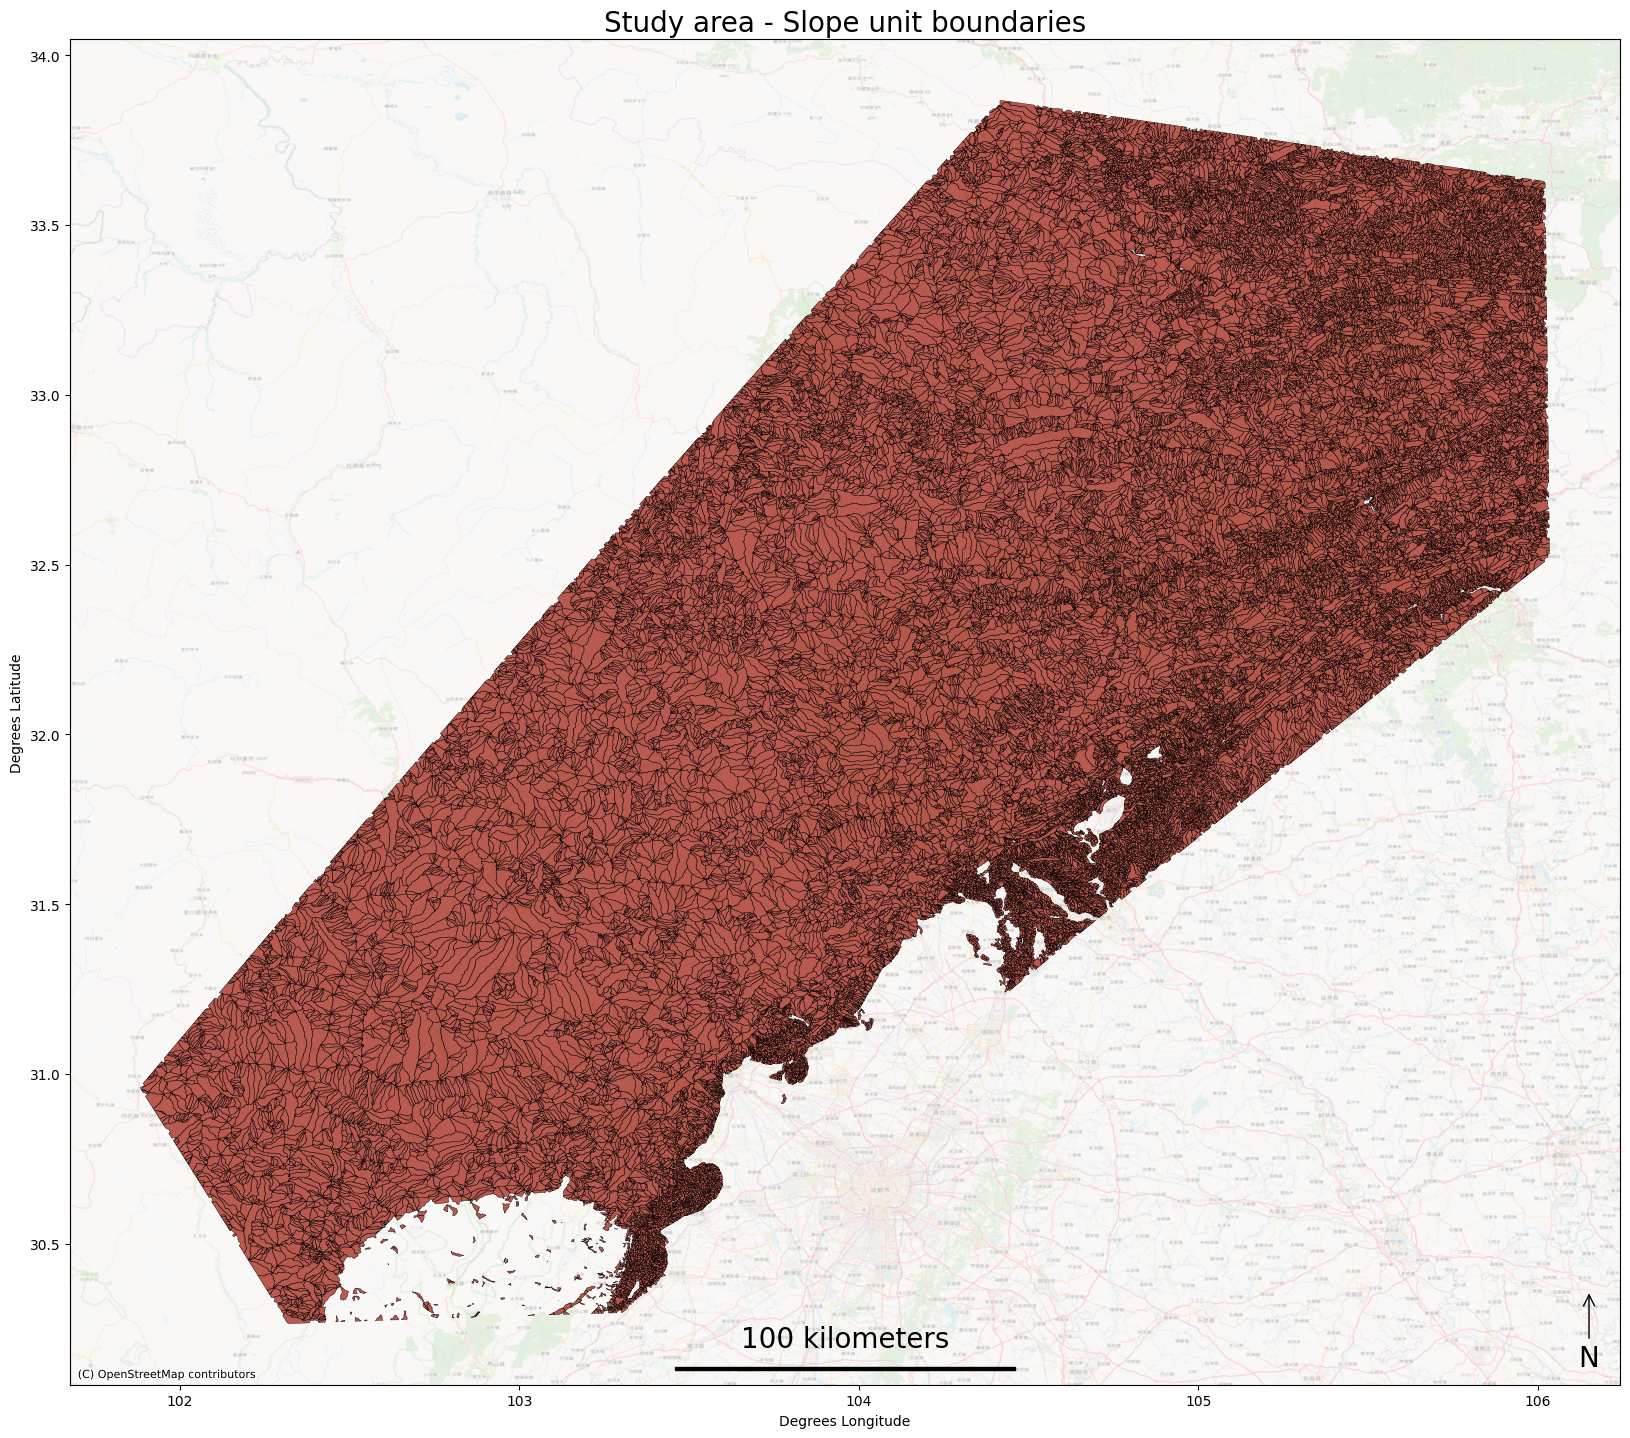

In [12]:
# Visualise the area with background
fig, ax = plt.subplots(figsize = (20,20))
slope_units.plot(ax=ax, color="#A93226", alpha=0.8, edgecolor='black', linewidth=0.3)

ctx.add_basemap(ax, zoom=10, crs=slope_units.crs, alpha=0.4, source=ctx.providers.OpenStreetMap.Mapnik)

# Add north arrow and scalebar
x, y, arrow_length = 0.98, 0.07, 0.05

ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(arrowstyle='->'),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

fontprops = matplotlib.font_manager.FontProperties(size=20, stretch='ultra-expanded')

scalebar = AnchoredSizeBar(ax.transData,
                           1, '100 kilometers', 'lower center', 
                           pad=0.5,
                           frameon=False,
                           size_vertical=0.01,
                           borderpad=0.02,
                           sep=10,
                           label_top=True,
                           fontproperties=fontprops)

ax.add_artist(scalebar)
ax.set_title("Study area - Slope unit boundaries")
ax.title.set_size(20)
ax.set_xlabel('Degrees Longitude', fontsize=10)
ax.set_ylabel('Degrees Latitude', fontsize=10)

plt.savefig('out/SU/imgs/study_area.png', bbox_inches='tight', pad_inches=0, dpi=600)

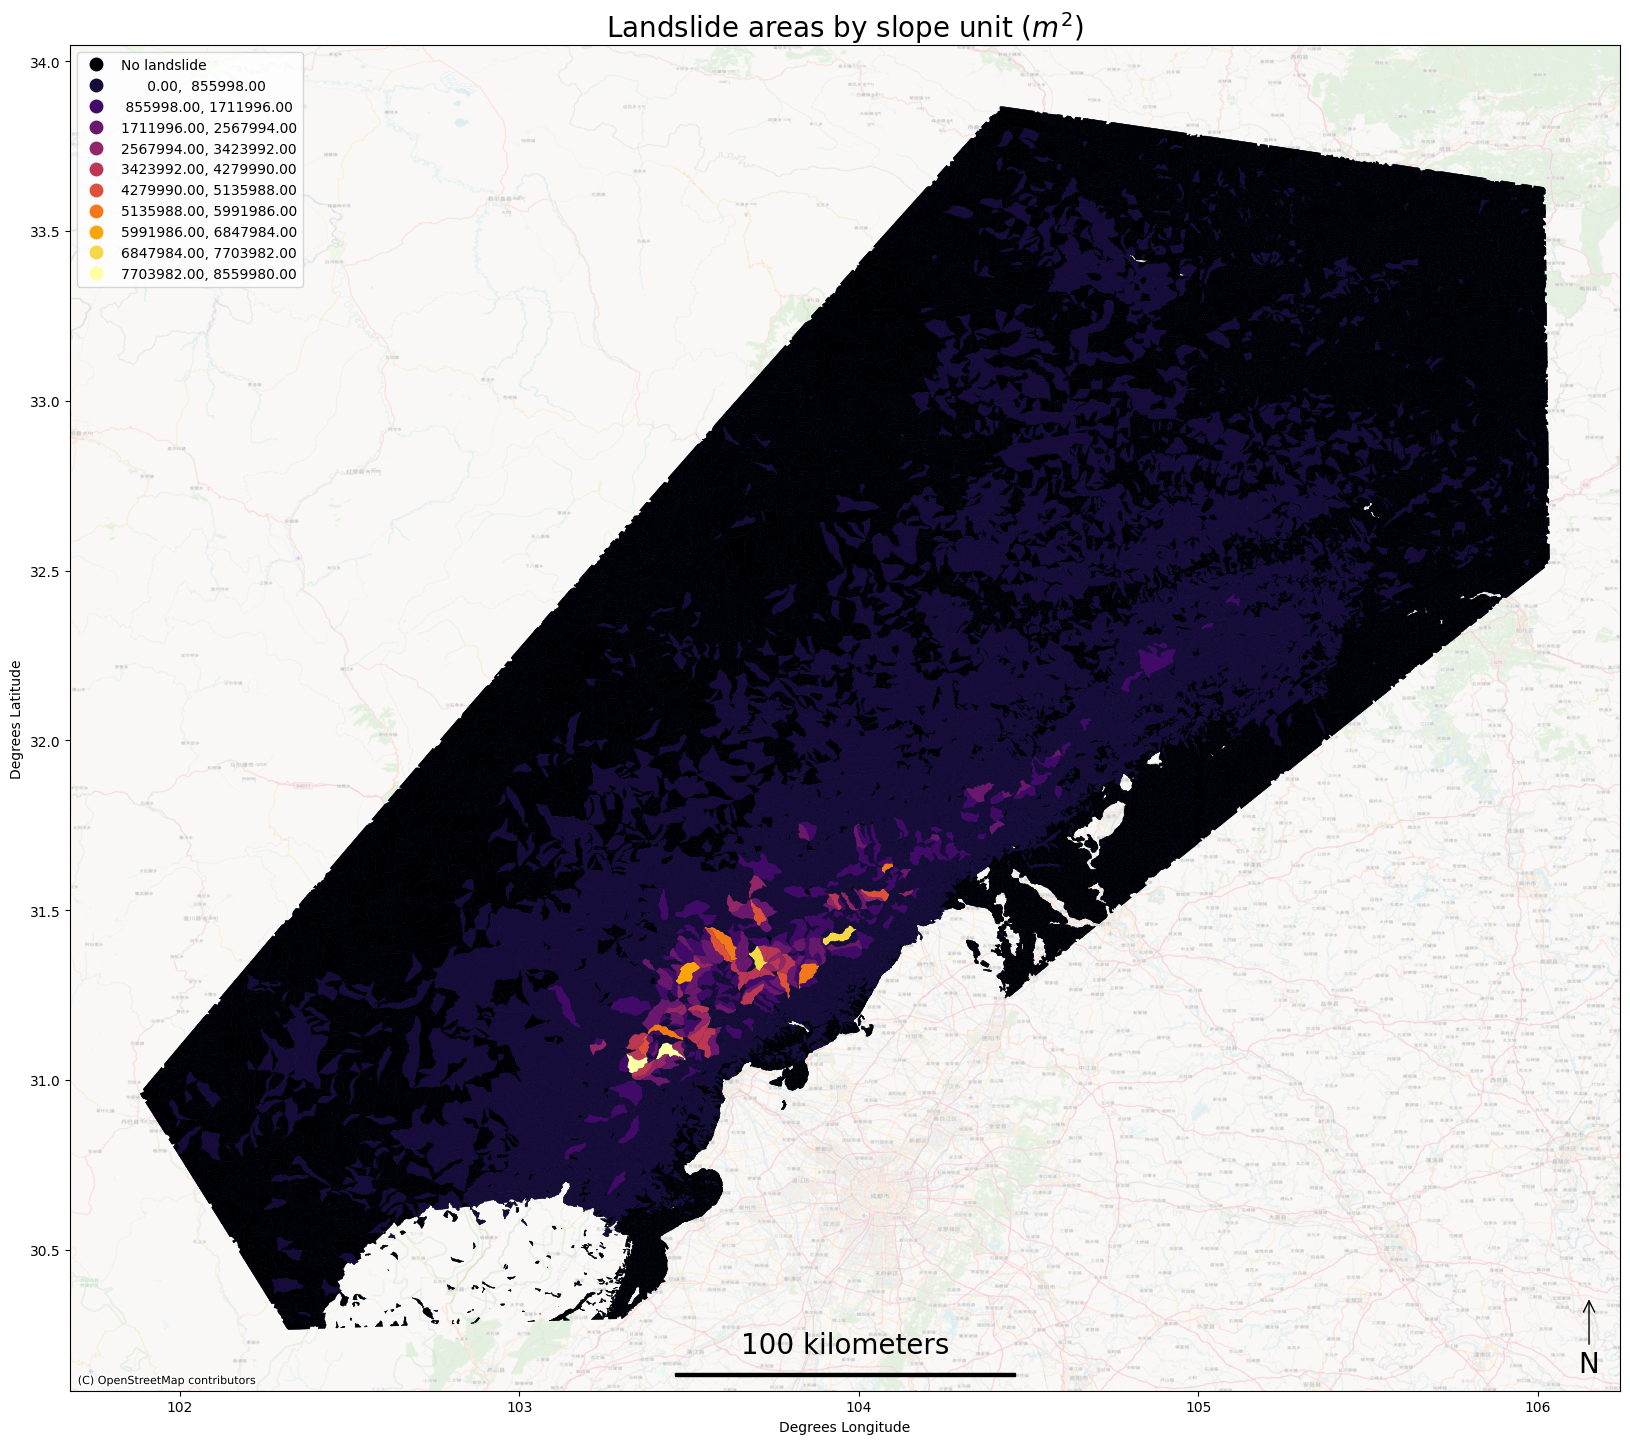

In [13]:
# Visualise the spatial distribution of landslides
fig, ax = plt.subplots(figsize = (20,20))
slope_units.plot(ax=ax, edgecolor='black', linewidth=0.3)

slope_units['Land_int'] = slope_units.Landslide_area_m2
slope_units = slope_units.astype({'Land_int':'int'})
val_max = slope_units.Land_int.max()
bins = [int(val_max * i / 10) for i in range(0,11)]

slope_units.plot(ax=ax, column='Land_int', cmap=matplotlib.colormaps['inferno'], 
                        legend=True, scheme='user_defined',
                        classification_kwds={'bins':bins},
                        legend_kwds = {"loc": "upper left"})
        
ctx.add_basemap(ax, zoom=10, crs=slope_units.crs, alpha=0.4, source=ctx.providers.OpenStreetMap.Mapnik)

# Add north arrow and scalebar
x, y, arrow_length = 0.98, 0.07, 0.05

ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(arrowstyle='->'),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

fontprops = matplotlib.font_manager.FontProperties(size=20, stretch='ultra-expanded')

scalebar = AnchoredSizeBar(ax.transData,
                           1, '100 kilometers', 'lower center', 
                           pad=0.5,
                           frameon=False,
                           size_vertical=0.01,
                           borderpad=0.02,
                           sep=10,
                           label_top=True,
                           fontproperties=fontprops)

ax.add_artist(scalebar)
ax.set_title("Landslide areas by slope unit ($m^{2}$)")
ax.title.set_size(20)

leg = ax.get_legend()
leg.get_texts()[0].set_text('No landslide')
ax.set_xlabel('Degrees Longitude', fontsize=10)
ax.set_ylabel('Degrees Latitude', fontsize=10)

plt.savefig('out/SU/imgs/real_full.png', bbox_inches='tight', pad_inches=0, dpi=600)

In [14]:
def pearson():
    slope_units.drop('Land_int', axis=1, inplace=True)
    corr = slope_units[slope_units.columns[1:-1]].corr()['Landslide_area_m2'][1:].values.reshape(-1,1)
    ax = sns.heatmap(corr, yticklabels=slope_units.columns[2:-1], cmap='vlag',annot=True)
    
    ax.set(xlabel="Landslide_area_m2", ylabel="Features")
    ax.xaxis.tick_top()

In [15]:
def visualise_extents():
    # For visualisation
    land_only_df = slope_units[slope_units['Landslide_area_m2']>0]

    # Visualise landslide area extents
    # Initialise a colour palette for plots.
    palette = sns.husl_palette(10)

    sns.set_theme(style="ticks", palette=palette, font_scale=2)
    sns.set_style("white")
    kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

    warnings.filterwarnings("ignore")
    y_dist = plt.figure(figsize=(15,10), dpi= 80)
    y_dist.suptitle('Landslide area / Slope unit area ratio')
    sns.distplot(land_only_df['Landslide_area_m2']/land_only_df['feat'], color=palette[5], **kwargs)
    
    plt.show()

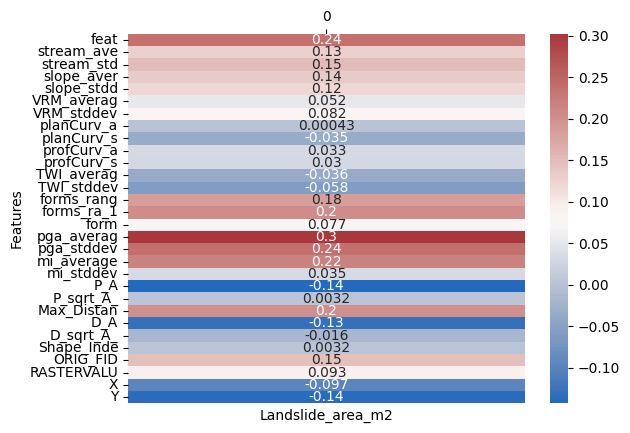

In [16]:
pearson()

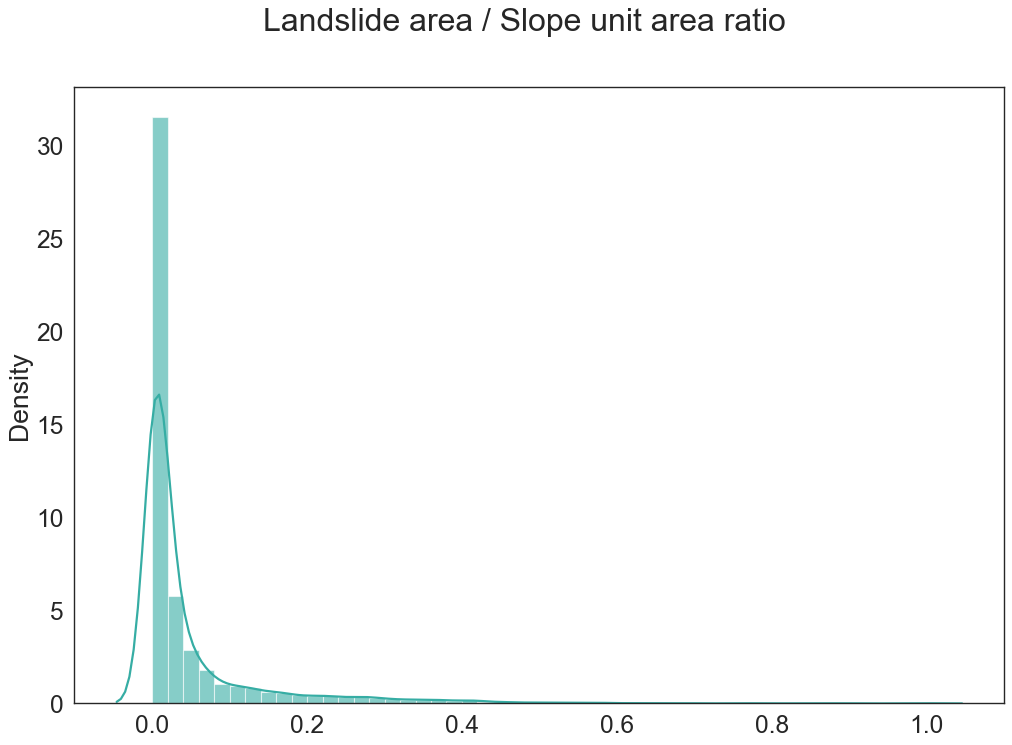

In [17]:
visualise_extents()

#### Data normalisation

In [18]:
def normalise_data():

    # Duplicate centroids coordinates to be normalised but keep the original to compute distances
    slope_units['X_nonstd'], slope_units['Y_nonstd'] = slope_units['X'], slope_units['Y']

    # Scaling
    t_and_attrs = slope_units.iloc[:,1:-3]

    scaler = MinMaxScaler().fit(t_and_attrs.values)
    
    standardised_data = scaler.transform(t_and_attrs.values)
    t_and_attrs = pd.DataFrame(standardised_data, columns = slope_units.columns[1:-3])
    
    # Rebuild the dataframe
    scaled = pd.concat([slope_units[['ID']], t_and_attrs,
                                    slope_units[['X_nonstd', 'Y_nonstd', 'geometry']]], axis = 1)        

    if extremes_only:
        scaled = scaled[scaled['Landslide_area_m2'] !=0]    
    
    # Back to geodataframe
    scaled = gpd.GeoDataFrame(scaled)
    
    return scaled

In [19]:
slope_units_scaled = normalise_data()

In [20]:
slope_units_scaled

ID  Landslide_area_m2      feat  stream_ave  stream_std  slope_aver  \
0          1           0.040337  0.081177    0.266299    0.469196    0.651657   
1          2           0.007932  0.012095    0.230530    0.300132    0.595326   
2          3           0.027298  0.120925    0.299241    0.505273    0.617437   
3          4           0.010035  0.084862    0.312633    0.458409    0.532128   
4          5           0.000000  0.049021    0.245568    0.422358    0.556961   
...      ...                ...       ...         ...         ...         ...   
36847  36848           0.000000  0.003989    0.243393    0.330713    0.310837   
36848  36849           0.000000  0.014509    0.259831    0.488888    0.551781   
36849  36850           0.000000  0.010275    0.165671    0.335991    0.400128   
36850  36851           0.000000  0.003522    0.124128    0.271168    0.186969   
36851  36852           0.000000  0.009937    0.150974    0.301334    0.056636   

       slope_stdd  VRM_averag  VRM_stddev  planCurv_a  ...       D_A  \
0        0.451839    0.199821    0.178805    0.604321  ...  0.016658   
1        0.348922    0.188303    0.186656    0.604979  ...  0.033850   
2        0.473638    0.199698    0.192608    0.604723  ...  0.005331   
3        0.386538    0.145995    0.175486    0.603842  ...  0.016176   
4        0.422774    0.219975    0.200266    0.605854  ...  0.007216   
...           ...         ...         ...         ...  ...       ...   
36847    0.570664    0.083277    0.083403    0.601206  ...  0.090299   
36848    0.392659    0.225380    0.254566    0.613999  ...  0.024985   
36849    0.513746    0.168015    0.151253    0.602370  ...  0.076411   
36850    0.268583    0.070979    0.053842    0.617791  ...  0.127212   
36851    0.093059    0.009187    0.007427    0.610663  ...  0.017462   

       D_sqrt_A_  Shape_Inde  ORIG_FID  RASTERVALU         X         Y  \
0       0.273549    0.256480  0.000000    0.533333  0.281182  0.106630   
1       0.056664    0.091744  0.000037    0.266667  0.271979  0.105042   
2       0.080684    0.151282  0.000112    0.000000  0.251635  0.105571   
3       0.467728    0.524524  0.000150    0.266667  0.240736  0.105488   
4       0.019685    0.060340  0.000412    0.266667  0.188181  0.091469   
...          ...         ...       ...         ...       ...       ...   
36847   0.177169    0.235686  0.999339    0.333333  0.219424  0.003205   
36848   0.206426    0.161273  0.999351    0.266667  0.126423  0.000000   
36849   0.202374    0.300827  0.999364    0.266667  0.315331  0.062540   
36850   0.191201    0.168038  0.999376    0.333333  0.345120  0.062456   
36851   0.055120    0.234605  1.000000    0.333333  0.608138  0.312895   

       X_nonstd  Y_nonstd                                           geometry  
0       103.060   30.6541  MULTIPOLYGON (((103.07653 30.64974, 103.07563 ...  
1       103.022   30.6484  MULTIPOLYGON (((103.01843 30.64575, 103.01783 ...  
2       102.938   30.6503  MULTIPOLYGON (((102.95603 30.63286, 102.95604 ...  
3       102.893   30.6500  MULTIPOLYGON (((102.86795 30.62963, 102.86586 ...  
4       102.676   30.5997  MULTIPOLYGON (((102.68561 30.59462, 102.68531 ...  
...         ...       ...                                                ...  
36847   102.805   30.2830  MULTIPOLYGON (((102.80373 30.28591, 102.80374 ...  
36848   102.421   30.2715  MULTIPOLYGON (((102.40916 30.27148, 102.41005 ...  
36849   103.201   30.4959  MULTIPOLYGON (((103.20239 30.49130, 103.20238 ...  
36850   103.324   30.4956  MULTIPOLYGON (((103.32437 30.49734, 103.32437 ...  
36851   104.410   31.3942  MULTIPOLYGON (((104.40887 31.38727, 104.40887 ...  

[36852 rows x 35 columns]

In [21]:
slope_units_scaled[slope_units_scaled['Landslide_area_m2'] > 0].describe()

ID  Landslide_area_m2         feat   stream_ave   stream_std  \
count   8775.000000        8775.000000  8775.000000  8775.000000  8775.000000   
mean   23630.499031           0.015339     0.043568     0.231794     0.374994   
std     8133.059055           0.048482     0.063420     0.064941     0.102447   
min        1.000000           0.000013     0.000012     0.032344     0.037101   
25%    18199.000000           0.000555     0.008981     0.190633     0.309787   
50%    24145.000000           0.001899     0.022090     0.229016     0.371258   
75%    30814.500000           0.008531     0.051756     0.268121     0.434651   
max    36787.000000           1.000000     1.000000     0.790228     1.000000   

        slope_aver   slope_stdd   VRM_averag   VRM_stddev   planCurv_a  ...  \
count  8775.000000  8775.000000  8775.000000  8775.000000  8775.000000  ...   
mean      0.487378     0.402559     0.166966     0.174830     0.604687  ...   
std       0.103345     0.081787     0.063487     0.061878     0.008304  ...   
min       0.027885     0.038260     0.002994     0.001985     0.000000  ...   
25%       0.428141     0.350862     0.124822     0.136698     0.602748  ...   
50%       0.498738     0.394557     0.163257     0.173154     0.604789  ...   
75%       0.558806     0.445104     0.204313     0.209223     0.606851  ...   
max       1.000000     1.000000     1.000000     1.000000     0.708538  ...   

        Max_Distan          D_A    D_sqrt_A_   Shape_Inde     ORIG_FID  \
count  8775.000000  8775.000000  8775.000000  8775.000000  8775.000000   
mean      0.128020     0.019725     0.176393     0.233463     0.812305   
std       0.082391     0.012606     0.093609     0.106309     0.103056   
min       0.027480     0.000000     0.001661     0.017221     0.000000   
25%       0.072055     0.010213     0.105159     0.157284     0.744843   
50%       0.106043     0.017033     0.159868     0.214211     0.819003   
75%       0.160029     0.026436     0.230434     0.287839     0.902186   
max       1.000000     0.102553     0.648359     0.906542     0.989810   

        RASTERVALU            X            Y     X_nonstd     Y_nonstd  
count  8775.000000  8775.000000  8775.000000  8775.000000  8775.000000  
mean      0.197690     0.574763     0.460136   104.272197    31.922512  
std       0.214439     0.181596     0.192368     0.749811     0.690235  
min       0.000000     0.022281     0.011092   101.991000    30.311300  
25%       0.000000     0.431581     0.315989   103.681000    31.405300  
50%       0.266667     0.586341     0.467378   104.320000    31.948500  
75%       0.333333     0.723056     0.596221   104.884500    32.410800  
max       1.000000     0.991281     0.979571   105.992000    33.786300  

[8 rows x 34 columns]

In [21]:
# Save the revised geodataframe
slope_units_scaled.to_file("data/custom/Wenchuan_data_final.gpkg", driver="GPKG")

#### Split data in tiles

In [22]:
def make_bb_and_tiles(tiles_per_row):
    # Creating the area bounding box
    minmax_coords = slope_units_scaled.bounds
    x_min, x_max = minmax_coords.minx.min(), minmax_coords.maxx.max()
    y_min, y_max = minmax_coords.miny.min(), minmax_coords.maxy.max()
    bottom_left = Point(x_min, y_min)
    bottom_right = Point(x_max, y_min)
    top_left = Point(x_min, y_max)
    top_right = Point(x_max, y_max)

    poly_area = Polygon([bottom_left, bottom_right, top_right, top_left])
    
    print(f'Selected grid: {tiles_per_row} x {tiles_per_row}')
    x_step = (x_max - x_min) / tiles_per_row
    y_step = (y_max - y_min) / tiles_per_row

    # Create the sub-boxes
    p1 = Point(top_left)
    p2 = Point(x_min + x_step, y_max)
    p3 = Point(x_min + x_step, y_max - y_step)
    p4 = Point(x_min, y_max - y_step)

    box_lst = []
    for i in range(tiles_per_row **2):
        box_lst.append(Polygon([p1, p2, p3, p4]))

        p1 = p2
        p2 = Point(p2.x + x_step, p2.y)
        p3 = Point(p3.x + x_step, p3.y)
        p4 = Point(p4.x + x_step, p4.y)

        if (i+1) % tiles_per_row == 0:
        # Go down one row
            p1 = Point(x_min, p3.y)
            p2 = Point(x_min + x_step, p3.y)
            p3 = Point(p2.x, p2.y - y_step)
            p4 = Point(x_min, p3.y)

    # Visualise the area and the tiles
    f, ax = plt.subplots(figsize=(10, 10))
    slope_units_scaled.plot(ax=ax, edgecolor='black')
    ax.plot(*poly_area.exterior.xy, color="black")

    for box in box_lst:
        ax.plot(*box.exterior.xy, color="blue", alpha=0.3)

    ax.set_axis_off()
    plt.show()
    #plt.savefig('out/SU/imgs/tiles grid.png', bbox_inches='tight', pad_inches=0, dpi=600)
    
    return box_lst

In [23]:
def assign_units(tiles_per_row):
    # Assign slope_units to each tile
    print('Assigning slope units to tiles...')
    units_per_box = []
    
    slope_units_scaled['centroid'] = [Point(xy) for xy 
                                   in zip(slope_units_scaled.X_nonstd, slope_units_scaled.Y_nonstd)] 

    box_dfs_lst = []
    
    for box in box_lst:
        df = slope_units_scaled.copy()        
        df = df.set_geometry("centroid")
        df['intersects_box'] = df.intersects(box)
        df = df[df['intersects_box'] == True].reset_index(drop=True)
        df = df.set_geometry("geometry")
        df.drop(['centroid'],axis=1, inplace=True)
        
        if df.empty:
            box_dfs_lst.append(None)
        else:
            box_dfs_lst.append(df)
                 
    slope_units_scaled.drop(['centroid'],axis=1, inplace=True)
    
    nodes = 0
    to_be_removed = tiles_per_row**2
    for i in box_dfs_lst:
        if i is not None:
            to_be_removed -= 1
            nodes += len(i)

    print(f'Total number of nodes: {nodes}')        
    print(f'Total number of tiles: {tiles_per_row**2}')
    print(f'Empty tiles: {to_be_removed}')
    print(f'Average number of nodes per box excluding empty boxes: {nodes / (tiles_per_row**2 - to_be_removed)}')

    # Remove empty dataframes (no slope units in the box)
    box_dfs_lst = [(i, box, box['Landslide_area_m2'].mean()) for i, box in enumerate(box_dfs_lst) if box is not None]

    print(f'Tiles kept: {len(box_dfs_lst)}')
    
    average = [item[2] for item in box_dfs_lst]
    print(f'Average target value in the dataset: {sum(average) / len(average)}')
    
    return box_dfs_lst

In [24]:
def split_sets():

    deciles = []
    
    random.shuffle(box_dfs_lst)
    num_boxes = len(box_dfs_lst)

    for i in range(10):

        box_dfs_lst_cp = box_dfs_lst.copy() 

        fract_i = i/10
        idx_min = int(fract_i * num_boxes)
        idx_max = int((fract_i + 0.1) * num_boxes)

        test = box_dfs_lst_cp[idx_min:idx_max]
        del box_dfs_lst_cp[idx_min:idx_max]

        random.shuffle(box_dfs_lst_cp)

        train = box_dfs_lst_cp[:int(0.75 * num_boxes)]
        val = box_dfs_lst_cp[int(0.75 * num_boxes):]
        
        three_sets = [train, val, test]
        deciles.append(three_sets)

    #Write tiles to file
    with open('data/custom/Wenchuan_by_tile.pkl', 'wb') as f:
        pickle.dump(deciles, f)

    return deciles

In [25]:
# Read tiles from file or create the new grid with the new parameters 
if not update_tiles:
    try:
        with open('data/custom/Wenchuan_by_tile.pkl', 'rb') as f:
            deciles_lst = pickle.load(f)
            print('Loading tiles...')
    except FileNotFoundError:
        print('Tiles not found, creating new tiles')
        box_lst = make_bb_and_tiles(tiles_per_row)
        box_dfs_lst = assign_units(tiles_per_row)
        deciles_lst = split_sets()
else:
    print('Creating new tiles...')
    box_lst = make_bb_and_tiles(tiles_per_row)
    box_dfs_lst = assign_units(tiles_per_row)
    deciles_lst = split_sets()

Loading tiles...


#### Create adjacency matrices

In [26]:
def make_rooks():
    rooks = []
    for theset in decile:
        rooks.append([weights.Rook.from_dataframe(df) for df in theset])
    
    return rooks

In [27]:
def visualise_neighbors(graph, theset):
    # Number of nodes per number of edges
    hist = graph.histogram
    hist = pd.DataFrame(hist, columns = ['Number of neighbors', 'Frequency'])

    y_pos = np.arange(len(hist['Frequency']))

    fig, ax = plt.subplots(figsize=(15, 10), dpi=80)

    hbars = ax.barh(y_pos, hist['Frequency'], align='edge')
    ax.set_yticks(y_pos, labels=hist['Number of neighbors'])
    ax.invert_yaxis()
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Number of neighbors')

    ax.set_title(f'Number of nodes (slope units) per number of edges (neighbors) - {theset} set sample')

    ax.bar_label(hbars)

    plt.show()

#### Create (full or unconnected) networkx graphs

In [28]:
def make_graphs():
    nx_G_lst = []
    if full_gs:
        # Creating fully connected graphs
        for rooks in rooks_lst: 
            nx_G_lst.append([nx.complete_graph(rook.to_networkx()) for rook in rooks])
    else:    
        # Creating graphs with edges for adjacent nodes only
        for rooks in rooks_lst: 
            nx_G_lst.append([rook.to_networkx() for rook in rooks])
    
    return nx_G_lst

#### Define the calculation for target relevances

In [29]:
def make_rel(param, form):
    if form == 'exp':
        return np.exp(param)
    elif form == 'log':
        return np.log(param+10**(-3))
    else:
        return np.power(param,form)

# Define the relevance normalisation equation (between 1 and 2)
def norm_equation(val, min_a, max_a, form):
    if not form == 'const':
        return 1 + (((make_rel(val, form) - make_rel(min_a, form)) / (make_rel(max_a, form) - make_rel(min_a, form))))
    else:
        return 1

In [30]:
def extract_node_attrs(idx):
    
    attrs = slope_units_scaled.columns[:-5].tolist()
    
    # Dataframe for visualisation purposes
    visual_df = pd.DataFrame()

    # Extract node attributes from the geodataframe for each df of the three sets
    attr_dict_lst = []
    for theset in decile:   
        attr_dict_lst.append([df[attrs].T.to_dict('dict') for df in theset])
            
    # Add the chosen attributes to calculate relevances on
    added_attrs = []
    for attr_lst in attr_dict_lst:
        for attr_dict in attr_lst:    
            for k in attr_dict.keys():    
                    # Calculate and normalise relevances
                    added = attr_dict[k]['Landslide_area_m2']          
                    added_attrs.append(added)
    
    min_added, max_added = min(added_attrs), max(added_attrs)
        
    # Calculate all target relevances
    count=0
    all_rels = []
    for attr_lst in attr_dict_lst:
        for attr_dict in attr_lst:    
            for k in attr_dict.keys():    
                    # Calculate and normalise relevances
                    rel8 = norm_equation(added_attrs[count], min_added, max_added, 1/8)
                
                    expo = norm_equation(added_attrs[count], min_added, max_added, 'exp')
                    rel2power = norm_equation(added_attrs[count], min_added, max_added, 2)                    
                    log = norm_equation(added_attrs[count], min_added, max_added, 'log')
                    rel2 = norm_equation(added_attrs[count], min_added, max_added, 1/2)                    
                    rel3 = norm_equation(added_attrs[count], min_added, max_added, 1/3)                    
                    rel5 = norm_equation(added_attrs[count], min_added, max_added, 1/5)                    
                    rel10 = norm_equation(added_attrs[count], min_added, max_added, 1/10)                    
                    rel20 = norm_equation(added_attrs[count], min_added, max_added, 1/20)    
                    linear = norm_equation(added_attrs[count], min_added, max_added, 1)
                    constant = norm_equation(added_attrs[count], min_added, max_added, 'const')
                    
                    all_rels.append((rel8, expo, rel2power, log, rel2, rel3, rel5, rel10, rel20, linear, constant))
    
                    count+=1
                
    # Condense all attributes into one feature (feat) for the three sets    
    count=0
    condensed_feats_lst_per_set = []
    
    for attr_lst in attr_dict_lst:
        condensed_feats_lst = []

        for attr_dict in attr_lst:    
            attr_dict_feat_condensed = {}

            for k in attr_dict.keys():   
                    
                    rel = all_rels[count]
                    attr_dict_feat_condensed[k] = {'target' : [attr_dict[k]['Landslide_area_m2'], rel[0], attr_dict[k]['ID']],
                                                   'feat' : [val for key, val in attr_dict[k].items() if key not in ['Landslide_area_m2','ID']]}
                
                    visual_df = pd.concat([visual_df, pd.DataFrame([{'Tar':attr_dict[k]['Landslide_area_m2'],
                                                                     'Rel_8': rel[0], 'Rel_expo': rel[1], 'Rel_2power': rel[2],
                                                                     'Rel_log': rel[3], 'Rel_2': rel[4], 'Rel_3': rel[5],
                                                                    'Rel_5': rel[6], 'Rel_10': rel[7], 'Rel_20': rel[8],
                                                                     'Rel_linear': rel[9], 'Rel_constant': rel[10]}])], ignore_index=True)
                    count+=1                    

            condensed_feats_lst.append(attr_dict_feat_condensed)
        condensed_feats_lst_per_set.append(condensed_feats_lst)

    # Visualise the relevance curves
    visual_df = pd.concat([visual_df[['Tar','Rel_8']].rename(columns={"Rel_8": "rel"}).assign(reltype='Eight root (best perf.)'),
                           visual_df[['Tar','Rel_expo']].rename(columns={"Rel_expo": "rel"}).assign(reltype='Exponential'),
                           visual_df[['Tar','Rel_2power']].rename(columns={"Rel_2power": "rel"}).assign(reltype='Square power'),
                           visual_df[['Tar','Rel_log']].rename(columns={"Rel_log": "rel"}).assign(reltype='Logarithmic'),
                           visual_df[['Tar','Rel_2']].rename(columns={"Rel_2": "rel"}).assign(reltype='Square root'),
                           visual_df[['Tar','Rel_3']].rename(columns={"Rel_3": "rel"}).assign(reltype='Cubic root'),
                           visual_df[['Tar','Rel_5']].rename(columns={"Rel_5": "rel"}).assign(reltype='Fifth root'),
                           visual_df[['Tar','Rel_10']].rename(columns={"Rel_10": "rel"}).assign(reltype='Tenth root'),
                           visual_df[['Tar','Rel_20']].rename(columns={"Rel_20": "rel"}).assign(reltype='Twentieth root'),
                           visual_df[['Tar','Rel_linear']].rename(columns={"Rel_linear": "rel"}).assign(reltype='Linear'),
                           visual_df[['Tar','Rel_constant']].rename(columns={"Rel_constant": "rel"}).assign(reltype='Constant')

                          ])

    visual_df['Tar'] = visual_df['Tar'] * slope_units['Landslide_area_m2'].max()

    if idx == 0:
        fig, ax = plt.subplots(figsize=(15,10), dpi=150)

        kwargs = dict(marker ='o')
        sns.scatterplot(data=visual_df.iloc[:int(len(visual_df)/11),:], x="Tar", y="rel",hue='reltype',palette='Reds',**kwargs)
        
        kwargs = dict(marker ='x')
        sns.scatterplot(data=visual_df.iloc[int(len(visual_df)/11):,:], x="Tar", y="rel",hue='reltype',palette='Greys',**kwargs)
   
        plt.title("Assigned relevance by landslide area: tested curves")
        ax.set_xlabel('Landslide area ($m^{2}$)', fontsize="14")
        ax.set_ylabel('Assigned relevance', fontsize="14")
        plt.grid()
        handles, labels = plt.gca().get_legend_handles_labels()
        order = [10,9,1,2,3,4,5,6,0,7,8]     
        plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower right', fontsize=10)
        ax.xaxis.set_ticks(np.arange(0, 9*10**6, 10**6))
        ax.yaxis.set_ticks(np.arange(1, 2.1, .1))

        plt.show()
        #plt.savefig('out/SU/imgs/relevances.pdf', bbox_inches='tight', pad_inches=0, dpi=150)

    return condensed_feats_lst_per_set

In [31]:
def add_node_attrs():
    # Check attributes correspond to nodes
    for set_feats, set_lst in zip(condensed_feats_lst_per_set, nx_G_lst):
        for feats, g in zip(set_feats, set_lst):
            if list(feats.keys()) != list(g.nodes):
                raise Exception('Unmatching nodes')

    # Add node attributes to the three graphs
    for set_lst, set_feats in zip(nx_G_lst, condensed_feats_lst_per_set):
        for g, feats in zip(set_lst, set_feats):
            nx.set_node_attributes(g, feats)

In [32]:
def calculate_w_edges():
    # Calculate weighted edges based on shared border length and centroid distances
    set_weight_lst = []
    set_edges_w_lst = []

    for set_gs, set_dfs in zip(nx_G_lst, decile):
        edges_w_lst = []
        weight_lst = []

        for nx_G, df in zip(set_gs, set_dfs):
            edges_w = {}
            lenghts, distances = [], []

            for edge in nx_G.edges:                     
                value = {}
                # Lenght of shared border
                node1_geom, node2_geom = df.iloc[edge[0]].geometry.buffer(0), df.iloc[edge[1]].geometry.buffer(0)
                bor = int(node1_geom.intersection(node2_geom).length * 10**4)

                # Distance between centroids
                node1_centroid = Point(df.iloc[edge[0]].X_nonstd, df.iloc[edge[0]].Y_nonstd)
                node2_centroid = Point(df.iloc[edge[1]].X_nonstd, df.iloc[edge[1]].Y_nonstd)
                dist = node1_centroid.distance(node2_centroid)
                
                value['feat'] = [bor, dist]
                lenghts.append(bor)
                distances.append(dist)

                edges_w[(edge[0], edge[1])] = value

            edges_w_lst.append(edges_w)
            weight_lst.append((lenghts, distances))

        set_edges_w_lst.append(edges_w_lst)
        set_weight_lst.append(weight_lst)
        
    return set_weight_lst, set_edges_w_lst

In [33]:
def normalise_edges():
    # Normalise edges
    len_dist_df = pd.DataFrame()
    
    for weights in set_weight_lst:
        for lenghts, distances in weights:

            len_dist_df = pd.concat([len_dist_df, pd.DataFrame(np.column_stack([lenghts, distances]), 
                                   columns=['lenghts', 'distances'])])

    scaler = MinMaxScaler().fit(len_dist_df.values)
    standardised_data = scaler.transform(len_dist_df.values)
    len_dist_df = pd.DataFrame(standardised_data, columns = ['lenghts', 'distances'])


    set_norm_edges_lst = []

    for weights in set_weight_lst:
        norm_edges_lst = []
        for lenghts, distances in weights:        
            rows = len(lenghts)

            normalized_len = len_dist_df['lenghts'].iloc[:rows].tolist()
            normalized_dist = len_dist_df['distances'].iloc[:rows].tolist()

            len_dist_df.drop(len_dist_df.index[:rows], inplace=True)

            if len(lenghts) != 0:
                norm_edges_lst.append((normalized_len, normalized_dist))
            else:
                norm_edges_lst.append(([None],[None]))

        set_norm_edges_lst.append(norm_edges_lst)
    
    return set_norm_edges_lst

In [34]:
def condense_edge_feats():
    # Create edges lists per set
    set_edges_w_norm_lst = []

    for theset1, theset2 in zip(set_edges_w_lst, set_norm_edges_lst):
        edges_w_norm_lst = []
        for edges_w, (normalized_len, normalized_dist) in zip(theset1, theset2):
            edges_w_norm = {}

            for k, l, d  in zip(edges_w.keys(), normalized_len, normalized_dist):
                edges_w_norm[k] = {'feat' : [round(l,4), round(d,4)]}

            edges_w_norm_lst.append(edges_w_norm)
        set_edges_w_norm_lst.append(edges_w_norm_lst)
    
    return set_edges_w_norm_lst

In [35]:
def add_edge_attrs():
    for theset1, theset2 in zip(set_edges_w_norm_lst, nx_G_lst):   
        for edges_w_norm, nx_G in zip(theset1, theset2):
            if list(edges_w_norm.keys()) != list(nx_G.edges):
                  raise Exception('Unmatching edges')

    # Add edge weights for the three graphs
    for theset1, theset2 in zip(nx_G_lst, set_edges_w_norm_lst):   

        for nx_G, edges_w_norm in zip(theset1, theset2):
            nx.set_edge_attributes(nx_G, edges_w_norm)

#### Convert to DGL graphs

In [36]:
def to_directed():
    # Convert to directed graphs (required for conversion to dgl)
    dir_subgraphs_per_set = []
    for theset in nx_G_lst:
        dir_subgraphs_per_set.append([nx.DiGraph(g) for g in theset])
    
    return dir_subgraphs_per_set

In [37]:
def to_dgl_graphs():
    node_attrs, edge_attrs = ['feat'], ['feat']
    
    dgl_subgs_per_set = []
    for dir_subgraphs in dir_subgraphs_per_set:
        dgl_subgs = []
        for subg in dir_subgraphs:
            if subg.number_of_edges() > 0:
                subg = dgl.from_networkx(subg, node_attrs=node_attrs, edge_attrs=edge_attrs)
            else:
                subg = dgl.from_networkx(subg, node_attrs=node_attrs)
            dgl_subgs.append(subg)
        dgl_subgs_per_set.append(dgl_subgs)
    
    return dgl_subgs_per_set

In [38]:
def merge():
    # Merging graphs and respective targets
    graphs_and_targets_per_set = []
    for dgl_subgs, torch_targets in zip(dgl_subgs_per_set, torch_targets_per_set):
        graphs_and_targets = [(g, t) for g, t in zip(dgl_subgs, torch_targets)]
        graphs_and_targets_per_set.append(graphs_and_targets)
    
    return graphs_and_targets_per_set

 ### Iterate over each test decile and create tensor graphs as output

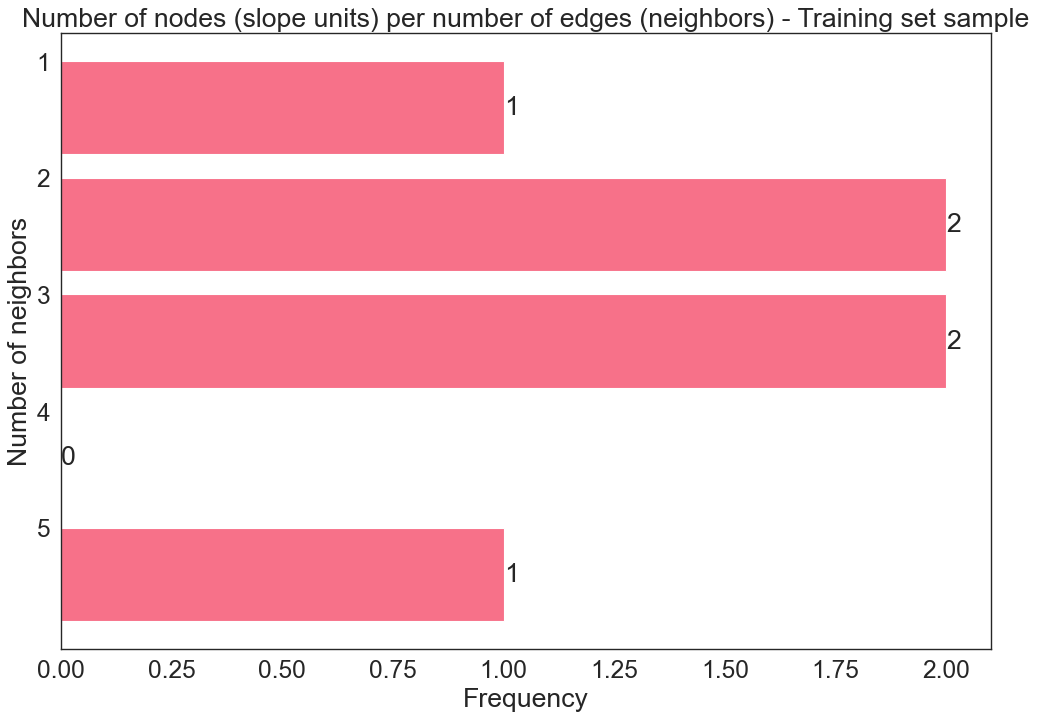

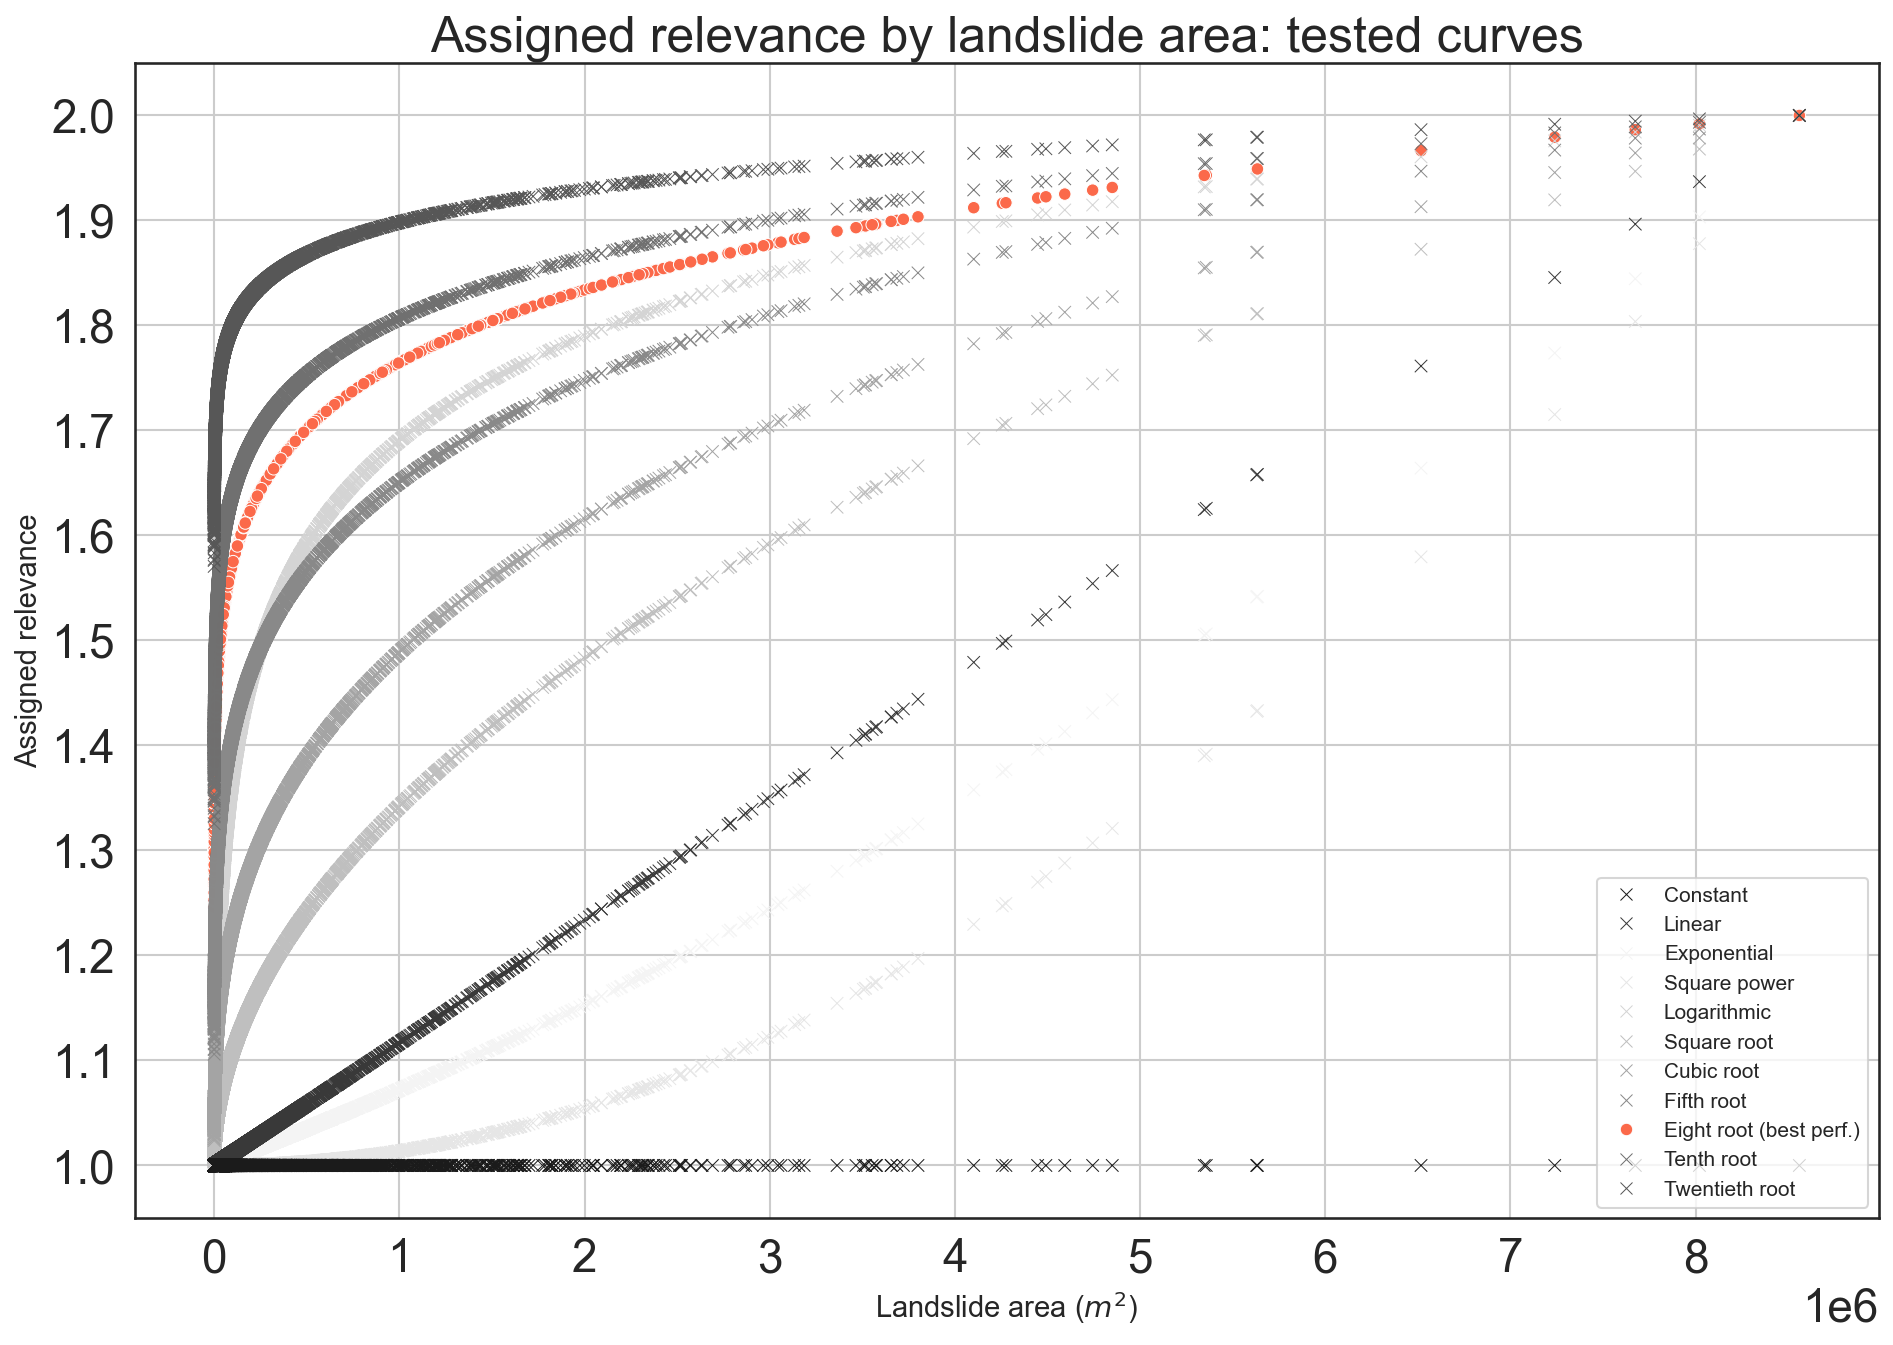

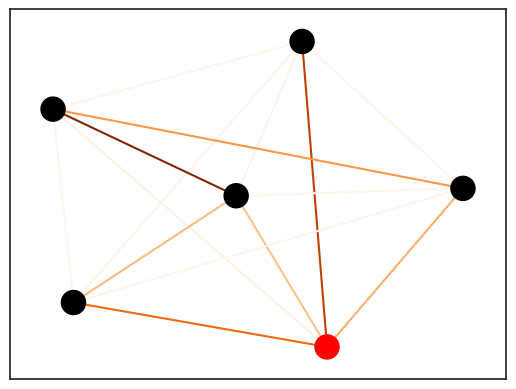

Non-zero target values per set: 6596
Non-zero target values per set: 1328
Non-zero target values per set: 851
[(Graph(num_nodes=6, num_edges=30,
      ndata_schemes={'feat': Scheme(shape=(28,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32)}), tensor([[2.3666e-03, 1.4696e+00, 1.0503e+04],
        [0.0000e+00, 1.0000e+00, 1.0629e+04],
        [0.0000e+00, 1.0000e+00, 1.0751e+04],
        [0.0000e+00, 1.0000e+00, 1.0877e+04],
        [0.0000e+00, 1.0000e+00, 1.0898e+04],
        [0.0000e+00, 1.0000e+00, 1.0993e+04]])), (Graph(num_nodes=11, num_edges=110,
      ndata_schemes={'feat': Scheme(shape=(28,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32)}), tensor([[0.0000e+00, 1.0000e+00, 5.7160e+03],
        [0.0000e+00, 1.0000e+00, 5.8030e+03],
        [0.0000e+00, 1.0000e+00, 5.8350e+03],
        [0.0000e+00, 1.0000e+00, 5.9750e+03],
        [4.2961e-04, 1.3794e+00, 5.9860e+03],
        [0.0000e+00, 1.0

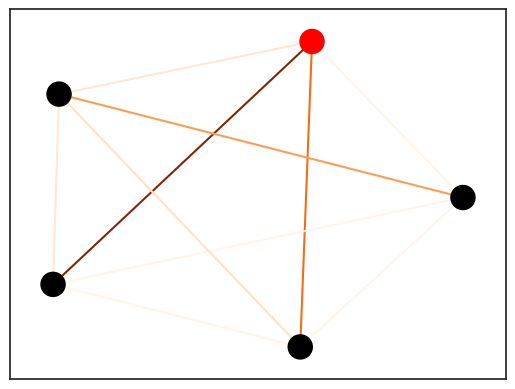

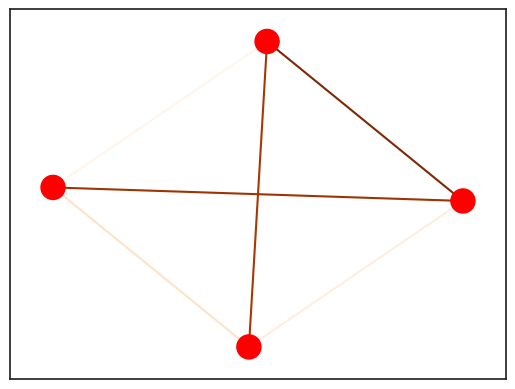

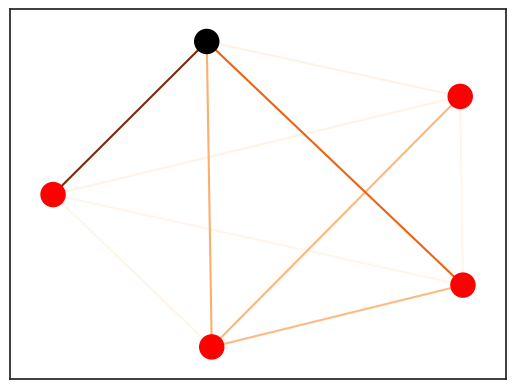

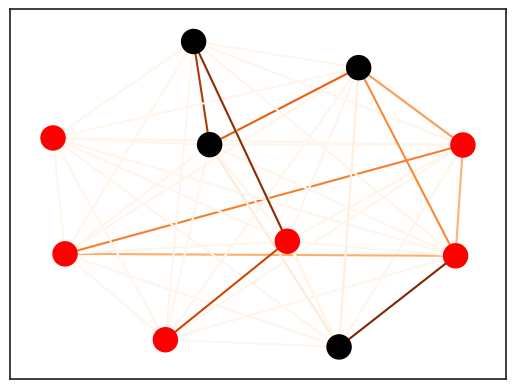

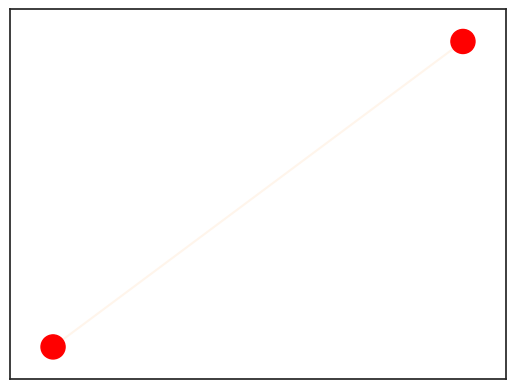

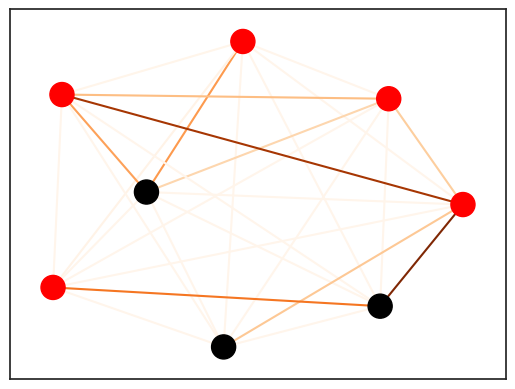

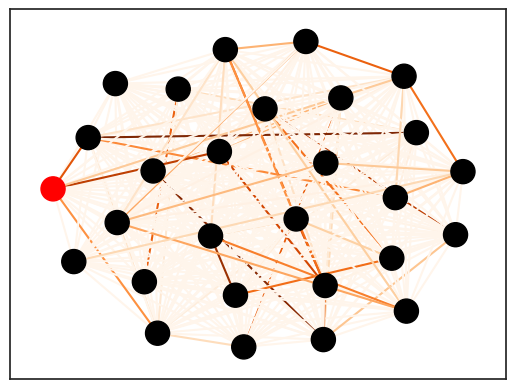

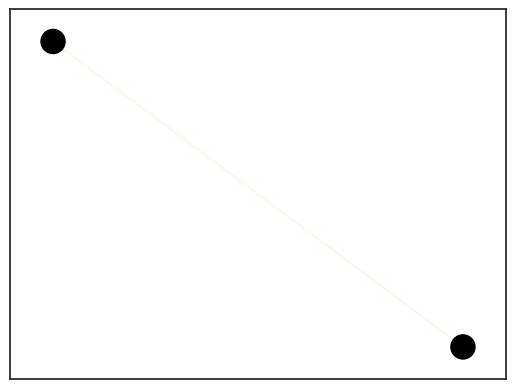

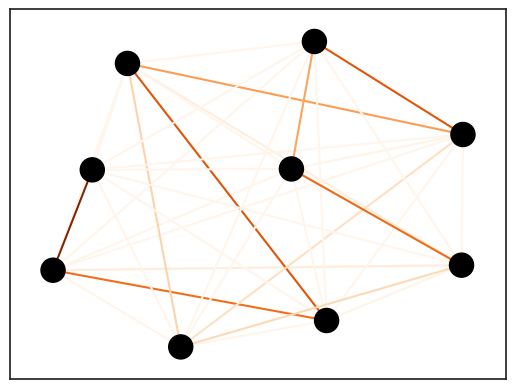

In [39]:
for idx, decile in enumerate(deciles_lst):

    train_df_lst = [item[1] for item in decile[0]]
    val_df_lst = [item[1] for item in decile[1]]
    test_df_lst = [item[1] for item in decile[2]]

    decile = [train_df_lst, val_df_lst, test_df_lst]

    rooks_lst = make_rooks()
    
    if idx == 0:
        visualise_neighbors(rooks_lst[0][0], 'Training')

    nx_G_lst = make_graphs()

    condensed_feats_lst_per_set = extract_node_attrs(idx)
    add_node_attrs()

    set_weight_lst, set_edges_w_lst = calculate_w_edges()
    set_norm_edges_lst = normalise_edges()
    set_edges_w_norm_lst = condense_edge_feats()
    add_edge_attrs()

    # Visualise a sample graph structure
    sample_g = nx_G_lst[0][idx]
    
    color = nx.get_node_attributes(sample_g,'target')
    colors = list(color.values())
    colors = ['black' if c[0] == 0 else 'red' for c in colors]
    
    e_colors = [a['feat'][0] for u,v,a in sample_g.edges(data=True)]
    
    options = {
        "node_color": colors,
        "edge_color": e_colors,
        "width" : 1.5,
        "edge_cmap": plt.cm.Oranges,
        "with_labels": False,
    }
    nx.draw_networkx(sample_g, **options)
    plt.show()
    #plt.savefig('out/SU/imgs/sample graph.png', bbox_inches='tight', pad_inches=0, dpi=600)

    dir_subgraphs_per_set = to_directed()

    # Retrieve the target variables
    torch_targets_per_set = []
    for subgraphs in dir_subgraphs_per_set:
        targets = [list(nx.get_node_attributes(sub, "target").values()) for sub in subgraphs]
        torch_targets = [torch.tensor(target, dtype=torch.float32) for target in targets]
        torch_targets_per_set.append(torch_targets)

    # Non-zero targets per set 
    if idx == 0:
        for targets in torch_targets_per_set:
            nonzero = 0
            for t in targets:
                for i in t:
                    if i[0] != 0:
                        nonzero += 1
            print(f'Non-zero target values per set: {nonzero}')

    dgl_subgs_per_set = to_dgl_graphs()

    graphs_and_targets_per_set = merge()
    
    # Sample output graph tensor
    if idx == 0:
        print(graphs_and_targets_per_set[0][:2])

    # Save output to file
    with open(f'data/custom/Wenchuan_TestIsDecile{idx+1}.pkl', 'wb') as f:
        pickle.dump(graphs_and_targets_per_set, f)

In [7]:
print(f'Elapsed time: {int((time.time() - start) / 60)} minutes')

Elapsed time: 45 minutes
